## model_selection

### This file does the following:
1. join tables from aws postgres database on animal services intake and outcome records, monthly animal services expenditures and monthly economic index to form clean data to model on.
2. calculate cross validation scores on all candidate models.
3. run random search cv and grid search cv on finalist models.
4. get best estimator of each finalist
5. compare accuracy and f1 scores of best estimator of each finalist.
6. random forest is the winner; plot its confusion matrix and feature importances

In [156]:
from __future__ import print_function, division
import pickle
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [3]:
connection_args = {
    'host': '54.200.221.80', # current aws instance public IP
    'user': 'ubuntu',    
    'dbname': 'proj3',   
    'port': 5432         
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)


In [4]:
from sqlalchemy import create_engine
import psycopg2 
import io

In [5]:
cur = connection.cursor()

In [8]:
query1 = """CREATE VIEW V1 AS (

  SELECT * FROM
    animal_services a
  LEFT JOIN 
      economic_index e 
  ON
    a.intake_year_month = e.year_month_index
 );"""

In [9]:
cur.execute(query1)

In [10]:
query2 = """CREATE VIEW V2 AS (

  SELECT * FROM 
    V1
  LEFT JOIN     
    expenses ex
    
  ON
    v1.intake_year_month = ex.year_month
  
);"""

In [11]:
cur.execute(query2)

In [14]:
df = pd.read_sql_query('select * from V2',con=connection)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141018 entries, 0 to 141017
Data columns (total 36 columns):
animaltype                     141018 non-null object
intaketype                     141018 non-null object
intakesubtype                  141018 non-null object
primarycolor                   141018 non-null object
primarybreed                   141018 non-null object
secondarybreed                 141018 non-null object
gender                         141018 non-null object
secondarycolor                 141018 non-null object
intakereason                   141018 non-null object
intakeinternalstatus           141018 non-null object
intakeasilomarstatus           141018 non-null object
reproductivestatusatintake     141018 non-null object
outcomeinternalstatus          141018 non-null object
outcomeasilomarstatus          141018 non-null object
reproductivestatusatoutcome    141018 non-null object
hasintakeage                   141018 non-null int64
hasoutcomeage             

In [18]:
X = df.drop(['intake_year_month','outcome_year_month','outcometype','year_month_index','year_month','date','month','year'],axis=1)
y = df.outcometype


In [20]:
#X.info()

In [21]:
X=pd.get_dummies(X)

In [22]:
X.shape

(141018, 93)

In [45]:
X['loiagridx'].replace(np.nan,-100,inplace=True)

In [46]:
X['scaled_loiagridx']=preprocessing.scale(X['loiagridx'])

In [50]:
X['amount'].replace(np.nan,-100,inplace=True)
X['scaled_amount']=preprocessing.scale(X['amount'])

In [51]:
X.drop(['loiagridx','amount'],axis=1, inplace=True)

In [53]:
X.shape

(141018, 93)

In [57]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444, stratify=y)


In [128]:
with open('X_train.pkl', 'wb') as fp:
    pickle.dump(X_train, fp)
with open('y_train.pkl', 'wb') as fp:
    pickle.dump(y_train, fp)
with open('X_test.pkl', 'wb') as fp:
    pickle.dump(X_test, fp)
with open('y_test.pkl', 'wb') as fp:
    pickle.dump(y_test, fp)

In [58]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [59]:
from sklearn.metrics import accuracy_score


In [60]:
cross_val_score(GaussianNB(),X_train,y_train).mean()


0.8062443557654099

In [61]:
cross_val_score(SVC(),X_train,y_train).mean()


0.9131817849839772

In [62]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [63]:
cross_val_score(DecisionTreeClassifier(),X_train,y_train).mean()


0.902960110050064

In [66]:
cross_val_score(RandomForestClassifier(),X_train,y_train).mean()


0.926037354392554

In [67]:
from sklearn.linear_model import LogisticRegression
cross_val_score(LogisticRegression(),X_train,y_train).mean()


0.9034261133891167

In [68]:
cross_val_score(KNeighborsClassifier(),X_train,y_train).mean()


0.8964765956948025

In [69]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, n_jobs=-1),X_train,y_train).mean()



0.9321561926895692

In [20]:
X.shape

(150062, 1040)

sklearn metrics scores

Scoring	Function	Comment
Classification	 	 
‘accuracy’	metrics.accuracy_score	 
‘average_precision’	metrics.average_precision_score	 
‘f1’	metrics.f1_score	for binary targets
‘f1_micro’	metrics.f1_score	micro-averaged
‘f1_macro’	metrics.f1_score	macro-averaged
‘f1_weighted’	metrics.f1_score	weighted average
‘f1_samples’	metrics.f1_score	by multilabel sample
‘neg_log_loss’	metrics.log_loss	requires predict_proba support
‘precision’ etc.	metrics.precision_score	suffixes apply as with ‘f1’
‘recall’ etc.	metrics.recall_score	suffixes apply as with ‘f1’
‘roc_auc’	metrics.roc_auc_score

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [71]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV] n_estimators=114, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   8.9s
[CV] n_estimators=114, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   9.0s
[CV] n_estimators=114, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


[CV]  n_estimators=86, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  11.6s
[CV] n_estimators=48, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min


[CV]  n_estimators=48, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   5.0s
[CV] n_estimators=48, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=171, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=  17.5s
[CV] n_estimators=48, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=48, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   4.9s
[CV] n_estimators=105, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=171, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=110, bootstrap=True, total=  17.0s
[CV] n_estimators=105, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=48, min_samples_s

[CV]  n_estimators=133, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=  12.1s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=133, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=  12.0s
[CV] n_estimators=181, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=133, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=True, total=  11.9s
[CV] n_estimators=181, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   5.5s
[CV] n_estimators=181, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=57, mi

[CV]  n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   9.0s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=181, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, total=  26.7s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=181, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, total=  26.3s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=67, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   8.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=20, mi

[CV]  n_estimators=181, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  24.0s
[CV] n_estimators=86, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total=  19.4s
[CV] n_estimators=86, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=86, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total=  12.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=86, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total=  12.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=20, min_samples_s

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min


[CV]  n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   5.5s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True 
[CV]  n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   5.6s
[CV] n_estimators=48, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=114, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=  15.7s
[CV] n_estimators=48, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=57, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=True, total=   5.6s
[CV] n_estimators=48, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=48, min_samples_spli

[CV]  n_estimators=48, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   6.4s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=190, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  25.3s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=48, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   6.3s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=57, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   5.3s
[CV] n_estimators=57, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=57, min_samples_s

[CV]  n_estimators=124, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  17.3s
[CV] n_estimators=181, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=124, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  17.2s
[CV] n_estimators=181, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=86, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=True, total=   7.9s
[CV] n_estimators=105, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=105, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=  14.8s
[CV] n_estimators=105, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=181, mi

[CV]  n_estimators=143, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  19.3s
[CV] n_estimators=76, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=143, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  19.5s
[CV] n_estimators=133, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=76, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=True, total=   7.3s
[CV] n_estimators=133, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=143, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  19.3s
[CV] n_estimators=133, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=76, 

[CV]  n_estimators=190, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=70, bootstrap=False, total=  25.8s
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.0s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=190, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=70, bootstrap=False, total=  26.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=190, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=70, bootstrap=False, total=  25.8s
[CV] n_estimators=86, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=86, m

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [20, 29, 38, 48, 57, 67, 76, 86, 95, 105, 114, 124, 133, 143, 152, 162, 171, 181, 190, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, ver

In [72]:
rf_random.best_score_

0.9353371423940352

In [73]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 181}

In [74]:
rf_random = rf_random.best_estimator_

In [90]:
for i in range(X.shape[1]):
    print(X.columns[i]+ ' : ', rf_random.feature_importances_[i])

hasintakeage :  0.009094113648431126
hasoutcomeage :  0.007821897416483654
hasdaysinshelter :  3.1791757694950337e-07
timesinshelter :  0.01576403935866566
scaledintakeyear :  0.02334125061821624
scaledintakemonth :  0.016034552672554162
scaledoutcomeyear :  0.02412890565921124
scaledoutcomemonth :  0.01603188638351384
scaledintakeageindays :  0.06424869787014643
scaledoutcomeageindays :  0.06540352460933237
scaleddaysinshelter :  0.1470058950479792
animaltype_CAT :  0.005904627122498263
animaltype_DOG :  0.005286373630834212
animaltype_OTHER :  0.002715753213329698
intaketype_FOSTER :  0.012286730549255657
intaketype_OTHER :  0.002429389641315659
intaketype_OWNER SUR :  0.00640731457970503
intaketype_RETURN :  0.0053195313642888
intaketype_STRAY :  0.008756515665336747
intaketype_medical :  0.01118686521212307
intakesubtype_ADOPTION :  0.004113906891049152
intakesubtype_FIELD :  0.005032544370901392
intakesubtype_OTC :  0.007108131990613137
intakesubtype_OTHER :  0.0030445495271983233

In [86]:
X.columns[-10]

'outcomeasilomarstatus_HEALTHY'

In [80]:
# Number of trees in random forest
param_grid = {'n_estimators': [175,180,185,190]}

In [81]:
from sklearn.model_selection import GridSearchCV


rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=175 ................................................
[CV] ................................. n_estimators=175, total=  14.3s
[CV] n_estimators=175 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s


[CV] ................................. n_estimators=175, total=  14.8s
[CV] n_estimators=175 ................................................
[CV] ................................. n_estimators=175, total=  14.2s
[CV] n_estimators=180 ................................................
[CV] ................................. n_estimators=180, total=  14.6s
[CV] n_estimators=180 ................................................
[CV] ................................. n_estimators=180, total=  15.0s
[CV] n_estimators=180 ................................................
[CV] ................................. n_estimators=180, total=  15.0s
[CV] n_estimators=185 ................................................
[CV] ................................. n_estimators=185, total=  15.3s
[CV] n_estimators=185 ................................................
[CV] ................................. n_estimators=185, total=  15.2s
[CV] n_estimators=185 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [175, 180, 185, 190]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [82]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
grid_search.best_score_

0.9345165734662453

In [ ]:
grid_search.

In [93]:
# Number of trees in random forest
n_estimators = [191, 200, 210, 220, 230, 240, 250]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [110, 120]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid1 = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [94]:
rf1 = RandomForestClassifier()
grid_search1 = GridSearchCV(estimator = rf1, param_grid = param_grid1, 
                          cv = 3, verbose = 2)
grid_search1.fit(X_train, y_train)



Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191, total=  14.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s


[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191, total=  15.3s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=191, total=  14.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  15.9s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200, total=  16.2s
[CV] bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200 
[CV]  bootstrap=True, max_de

[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=230, total=  18.2s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240, total=  18.6s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240, total=  19.0s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=240, total=  18.7s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=250 
[CV]  bootstrap=True, max_de

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed: 21.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [191, 200, 210, 220, 230, 240, 250], 'max_features': ['auto'], 'max_depth': [110, 120, None], 'min_samples_split': [5], 'min_samples_leaf': [1], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [95]:
grid_search1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=110, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=220, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
grid_search1.best_score_

0.9342633114514952

In [118]:
best_rf = grid_search.best_estimator_

In [ ]:
n_estimators = [191, 200, 210, 220, 230, 240, 250]
random_grid = {'base_estimator':DecisionTreeClassifier(),'n_estimators': n_estimators}
bc = BaggingClassifier()
bc_random=RandomizedSearchCV(estimator = bc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
bc_random.fit(X_train, y_train)


In [98]:

grid_search_logreg=GridSearchCV(cv=3,verbose = 2,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
grid_search_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.6s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .......................................... C=0.001, total=   0.5s
[CV] C=0.001 .........................................................
[CV] .......................................... C=0.001, total=   0.5s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   36.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [99]:
grid_search_logreg.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
best_logreg=grid_search_logreg.best_estimator_

In [100]:
grid_search_logreg.best_score_

0.9034767809384877

In [111]:
k_range = list(range(1,12, 5))
print(k_range)

[1, 6, 11]


In [112]:
param_grid = dict(n_neighbors=k_range)

In [113]:
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, verbose = 2)

In [114]:
grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total= 2.6min
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s


[CV] .................................... n_neighbors=1, total= 2.6min
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total= 2.6min
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total= 4.2min
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total= 4.1min
[CV] n_neighbors=6 ...................................................
[CV] .................................... n_neighbors=6, total= 4.2min
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total= 4.7min
[CV] n_neighbors=11 ..................................................
[CV] ................................... n_neighbors=11, total= 4.6min
[CV] n_neighbors=11 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 85.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 6, 11]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=2)

In [115]:
grid_search_knn.best_score_

0.899941243212578

In [157]:
best_knn = grid_search_knn.best_estimator_

In [158]:
best_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [133]:
import pickle
with open('best_knn.pkl', 'wb') as fp:
    pickle.dump(best_knn, fp)

In [125]:
with open('best_rf.pkl', 'wb') as fp:
    pickle.dump(best_rf, fp)

In [126]:
with open('best_logreg.pkl', 'wb') as fp:
    pickle.dump(best_logreg, fp)

In [129]:
y_test.value_counts()

not_adopted    34633
ADOPTION        7673
Name: outcometype, dtype: int64

In [138]:
y_test = y_test.replace('ADOPTION',0)
y_test = y_test.replace('not_adopted',1)

In [139]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, accuracy_score
def get_f1_score(model):
    
    y_predicted = model.predict(X_test)
    y_predicted = pd.DataFrame(y_predicted)
    y_predicted[0].replace('not_adopted',1,inplace=True)
    y_predicted[0].replace('ADOPTION',0,inplace=True)
    return f1_score(y_test,y_predicted[0])

In [140]:
logreg_f1 = get_f1_score(best_logreg)

In [141]:
logreg_f1

0.9424805444677369

In [142]:
rf_f1 = get_f1_score(best_rf)

In [143]:
rf_f1

0.9604765888699766

In [146]:
    y_predicted = best_rf.predict(X_test)
    y_predicted = pd.DataFrame(y_predicted)
    y_predicted[0].replace('not_adopted',1,inplace=True)
    y_predicted[0].replace('ADOPTION',0,inplace=True)
    y_pred = y_predicted[0]

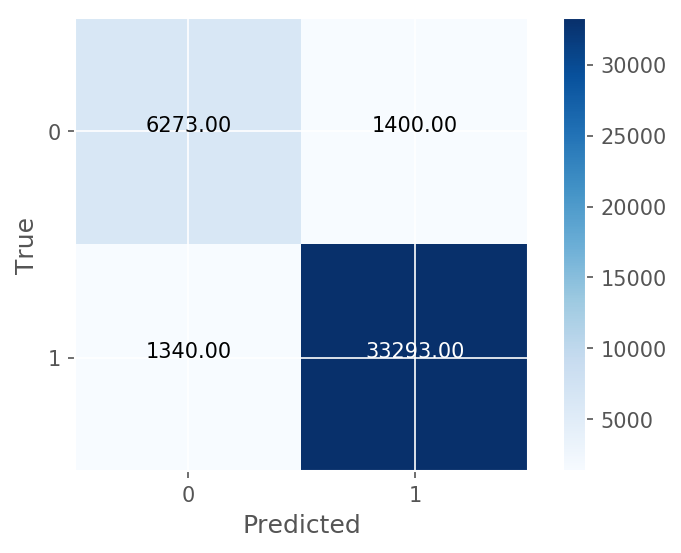

In [147]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

plt.figure(dpi=150)
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar();
plt.xticks([0,1])
plt.yticks([0,1]);
plt.ylabel("True")
plt.xlabel("Predicted");
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

In [150]:
# baseline estimators

def predict_adopted(X):
    if isinstance(X, pd.DataFrame):
        return [0]*X.shape[0]
    else:
        return [0]* X.size
    
def predict_not_adopted(X):
    if isinstance(X, pd.DataFrame):
        return [1]*X.shape[0]
    else:
        return [1]*X.size

In [151]:
predict_adopted_f1= f1_score(y_test,predict_adopted(X_test))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
predict_adopted_f1

0.0

In [154]:
predict_not_adopted_f1= f1_score(y_test,predict_not_adopted(X_test))

In [155]:
predict_not_adopted_f1

0.9002716437697397

In [159]:
pred_logprob=best_logreg.predict_proba(X_test)

In [160]:
#first col is probability for 0 --- adopted
#second col is probability for 1 --- not adopted
pred_logprob[:5]

array([[1.44648099e-03, 9.98553519e-01],
       [5.97432352e-04, 9.99402568e-01],
       [2.25327343e-02, 9.77467266e-01],
       [2.02226690e-02, 9.79777331e-01],
       [4.16415621e-03, 9.95835844e-01]])

In [161]:
pred_log=best_logreg.predict(X_test)

In [162]:
pred_log[:5]

array(['not_adopted', 'not_adopted', 'not_adopted', 'not_adopted',
       'not_adopted'], dtype=object)

In [178]:
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

In [165]:
feature_importances.head(10)

,importance
scaleddaysinshelter,0.144140
reproductivestatusatoutcome_ALTERED,0.101406
scaledoutcomeageindays,0.064016
scaledintakeageindays,0.058183
reproductivestatusatoutcome_FERTILE,0.054612
gender_SPAYED FEMALE,0.031782
scaled_loiagridx,0.028799
scaled_amount,0.026855
scaledoutcomeyear,0.024644
scaledintakeyear,0.024513


Text(0.5,0,'Relative Importance')

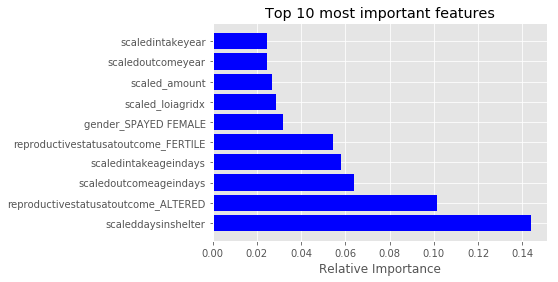

In [192]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

                 
plt.figure(1)
plt.title('Top 10 most important features')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_test.columns[indices])
plt.xlabel('Relative Importance')

In [191]:
print(X_test.columns[indices])

Index(['scaleddaysinshelter', 'reproductivestatusatoutcome_ALTERED',
       'scaledoutcomeageindays', 'scaledintakeageindays',
       'reproductivestatusatoutcome_FERTILE', 'gender_SPAYED FEMALE',
       'scaled_loiagridx', 'scaled_amount', 'scaledoutcomeyear',
       'scaledintakeyear'],
      dtype='object')
